# Logistic Regression Classifier for Doctor's Notes

## Dependencies

In [1]:
import time
import numpy as np
import pandas as pd
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from create_training_set import create_data

## Import Data and Preprocess

__Import Data__

In [2]:
start = time.time()
df = create_data()
end = time.time()
print("Time elapsed: ", end-start)

Do you wish to save to csv? Y/N:  N


Operation complete.  Quitting.
Time elapsed:  59.90169405937195


__Preprocess__

In [3]:
# Relabel Method from strings to a numerical representation (0 for 2d, 1 for 3d, and 2 for None)
df['METHOD'] = df['METHOD'].astype('category')
df['METHOD'] = df['METHOD'].cat.rename_categories({'2d simpson biplane': 0, '3d imaging': 1, 'None': 2})

In [4]:
# Cut the set down to just the cleaned Note Text and to the Label
df_copy = df # copy
df = df[['NOTE_CLEAN', 'METHOD']]
# Separate out the labels 
labels = np.array(df['METHOD'])
print("Shape of label vector: ", labels.shape)
print("Type: ", type(labels))

Shape of label vector:  (5056,)
Type:  <class 'numpy.ndarray'>


In [5]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(df['NOTE_CLEAN']).todense() # (documents, vocab)

print("Shape of document term matrix: ", vectors_tfidf.shape)
print("Type: ", type(vectors_tfidf))

Shape of document term matrix:  (5056, 3478)
Type:  <class 'numpy.matrix'>


__Preview Vocab__

In [6]:
vocab = np.array(vectorizer_tfidf.get_feature_names())

In [7]:
vocab[100:120]

array(['109', '10cm²', '10mm', '10mmhg', '10x', '11', '110', '111',
       '1110', '1114', '112', '112020', '1132', '114', '115', '1153',
       '1155', '116', '118', '119'], dtype='<U19')

__Create Target Array__

In [8]:
df['METHOD'].describe()
target = np.array(df['METHOD'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(vectors_tfidf, target)

## Re-sampling 

I use the same over and undersampling techniques we tried in the Multinomial NBC problem. 

__Undersample Majority Classes__

In [10]:
# Define undersampling strategy
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={0: 1000, 2: 1000})
# Fit and apply the transform 
X_under, y_under = undersample.fit_resample(X_train, y_train)

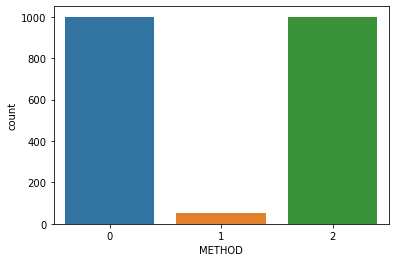

In [11]:
sns.countplot(x='METHOD', data = pd.DataFrame(y_under, columns=['METHOD']))

__Oversample Minority Classes__

In [12]:
# Define oversample strategy 
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority') # oversample minority class
# Fit and apply the transform
X_over, y_over = oversample.fit_resample(X_under, y_under)

__Result of re-sampling__

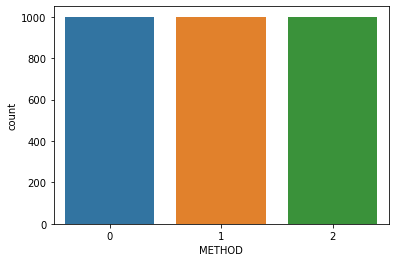

In [13]:
sns.countplot(x='METHOD', data = pd.DataFrame(y_over, columns=['METHOD']))

## Apply data to model and assess fitness

In [14]:
clf = LogisticRegression().fit(X_train, y_train)

In [15]:
# make predictions
yhat = clf.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
prec = precision_score(y_test, yhat, average='micro')
rec = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % prec)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

# Compute MSE to see how different things are 
mse = np.sum((y_test - yhat)**2)/len(y_test)
print("Mean Squared Error: %.4f" % mse)

Accuracy: 0.985
Precision: 0.985
Recall: 0.985
F1 Score: 0.985
Mean Squared Error: 0.0388


Text(0.5, 1.0, 'Confusion Matrix')

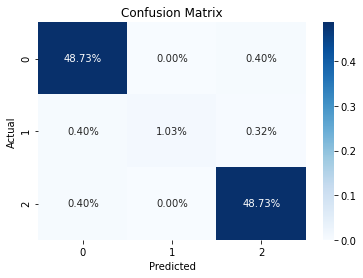

In [16]:
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')